## Model Deployment

- There are several ways to deploy a model.  This is a same notebook walking you through the process of 

In [1]:
#import packages needed for deployment
import azureml.core
from azureml.core import Workspace, Model
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

import pandas as pd

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.38.0 to work with mm-hackathon-prep


In [2]:
experiment_folder = 'prep_for_deploy'

import os
# Create a folder for the experiment files
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

prep_for_deploy folder created


### Create environment conda.yml file

Use a conda.yml file to specify the packages needed for model deployment

In [3]:
%%writefile $experiment_folder/experiment_env.yml
name: experiment_env
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2
- scikit-learn
- ipykernel
- matplotlib
- pandas
- pip
- pip:
  - azureml-defaults
  - pyarrow

Overwriting prep_for_deploy/experiment_env.yml


### Create an Azure ML enviornment

In [5]:
from azureml.core import Environment

# Create a Python environment for the experiment (from a .yml file)
experiment_env = Environment.from_conda_specification("experiment-env", experiment_folder + "/experiment_env.yml")

# Let Azure ML manage dependencies
experiment_env.python.user_managed_dependencies = False 

# Print the environment details
print(experiment_env.name, 'defined.')
print(experiment_env.python.conda_dependencies.serialize_to_string())

experiment-env defined.
name: experiment_env
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2
- scikit-learn
- ipykernel
- matplotlib
- pandas
- pip
- pip:
  - azureml-defaults
  - pyarrow



In [6]:
#set the model name as the model name registered from notebook 001, set the environment name that was registered above, 
#give your endpoint a name

model_name = 'titanic-model'
environment_name = 'experiment_env'
service_name = 'servicename'

### Create aci_config

- auth_enabled = True means that a key will be generated that you will use to make the api call

In [7]:

aci_config = AciWebservice.deploy_configuration(
            cpu_cores = 1, 
            memory_gb = 2, 
            tags = {'model': 'titanic model'},
            auth_enabled=True,
            enable_app_insights=True,
            collect_model_data=True)

## Testing a deployed service

-  You can test making the API call on the deployed service by using the 'Test' tab

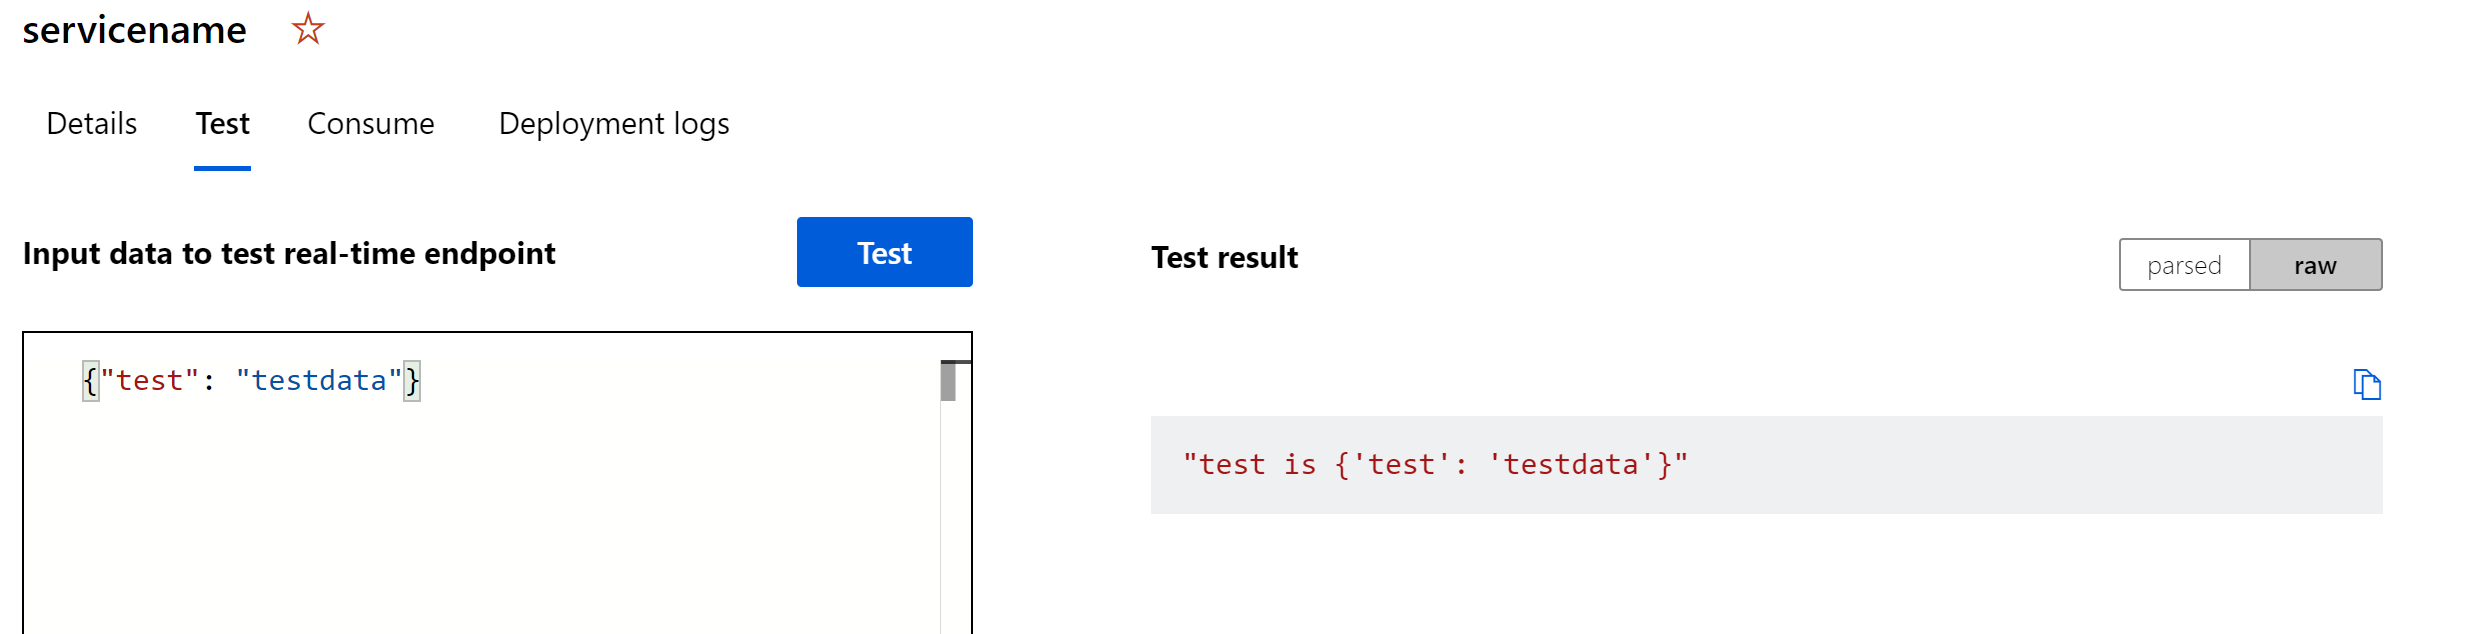

In [9]:
from IPython.display import Image

Image(filename="./image/Capture.png")

## Notes on preparing for API Call

- Manually grab url & api key, you can get them programmically & you will later in the notebook
- Be familiar with where in teh UI they are located.

## DEPLOY ME: Update the init script

In [10]:
%%writefile ./$experiment_folder/score.py

import os 
import json
import joblib
from pandas import json_normalize
import pandas as pd

def init():
    global model
    # Replace filename if needed.
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'titanic_model.pkl')
    # Deserialize the model file back into a sklearn model.
    model = joblib.load(model_path)

def run(data):
    dict= json.loads(data)
    df = json_normalize(dict['data']) 
    df['loc']= df['cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')
    df['hasFamily'] = (df['sibsp'] > 0) | (df['parch'] > 0)
    #note we remove the survived column
    cols_to_keep = ['pclass','sex','age','embarked','loc','hasFamily']
    df = df[cols_to_keep]
    
    print(df.isnull().sum())
    y_pred = model.predict(df)
    print(type(y_pred))
    
    #return json.dumps(y_pred)
    result = {"result": y_pred.tolist()}
    return result

Overwriting ./prep_for_deploy/score.py


## Deploying the model.

https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/deployment/deploy-to-cloud/model-register-and-deploy.ipynb

- 1. Retrieve the model from the workspace
- 2. Retrieve the environment from the workspace
- 3. Create an inference config specify the source directory, the score.py file, and the environment
- 4. Create a deployment config
- 5. Deploy the model passing: (this step will take up to 10 minutes)
    - workspace
    - service name
    - the model object
    - the inference config
    - the deployment 
    - set overwrite to true
- 6. Wait for deployment

- What is step 6 doing?  If you haven't deployed before, it will create an Azure Container Register, to register the container with your registered environment.  It will then create the ACI instance.


In [19]:
#get the model object from the workspace
model = Model(ws, model_name)
#get the environment from the workspace
env = Environment.get(ws, environment_name)

inference_config = InferenceConfig(source_directory=experiment_folder,
                                   entry_script='score.py',
                                   environment= env)

# Deploy the model as a service
print('Deploying model...')
service_name = "titanic-service"
service = Model.deploy(ws, service_name, [model], inference_config, aci_config, overwrite=True)

Deploying model...


What is going on - you are deploying an ACI instance, in the resource group where AML lives


You can go into that ACI instance and check out the logs there.  Click on **containers** on the left menu, 

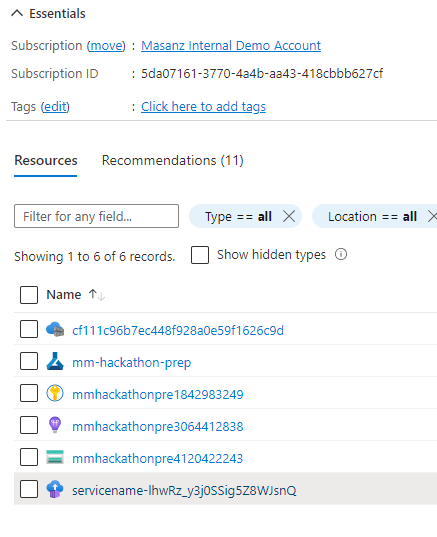

In [23]:
from IPython.display import Image

Image(filename="./image/ACI_001.PNG")

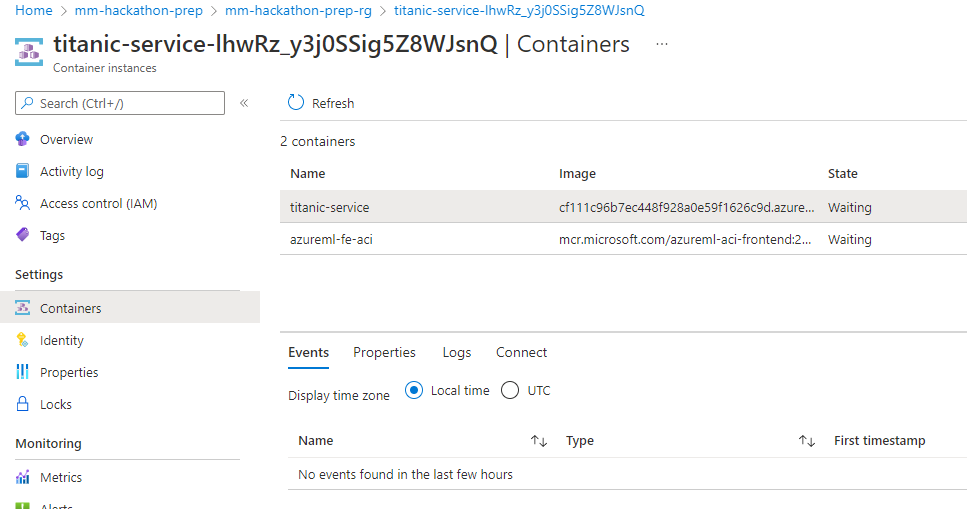

In [25]:
from IPython.display import Image

Image(filename="./image/ACI_002.PNG")

## You deployment logs in AML workspace come from the logs in your ACI instance

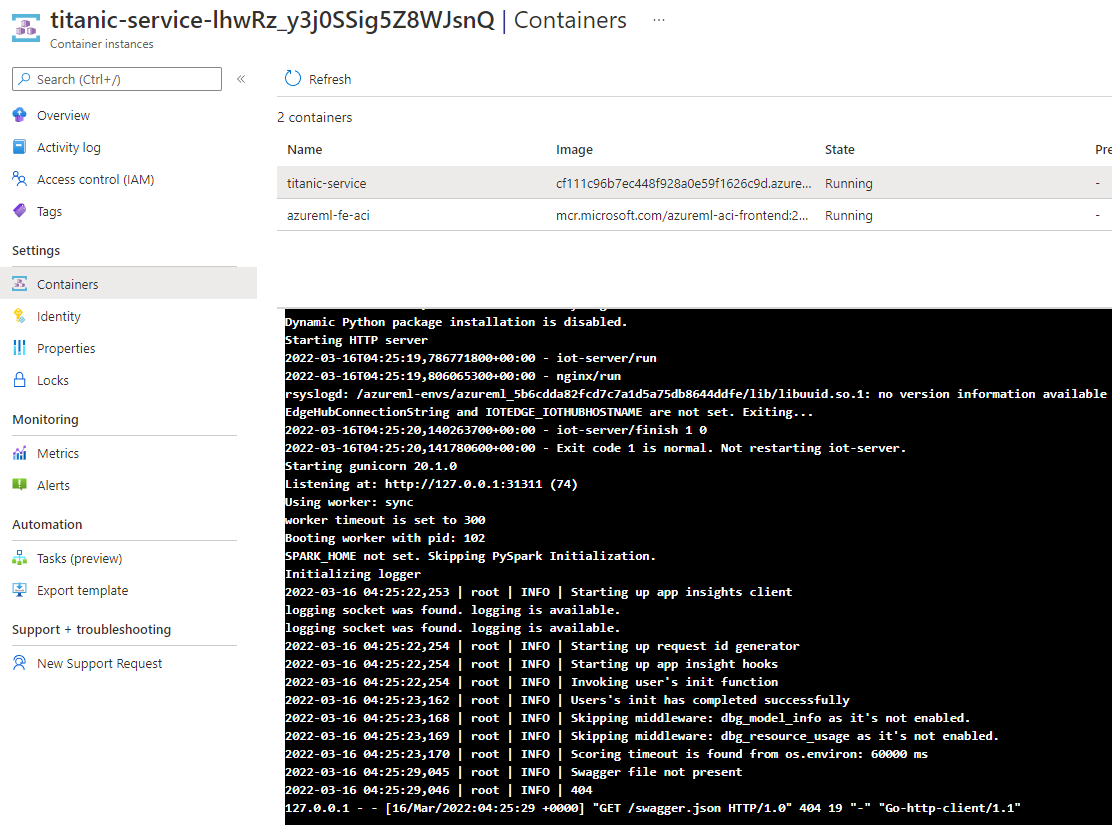

In [27]:
from IPython.display import Image

Image(filename="./image/ACI_003.PNG")

In [20]:
service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-03-16 04:21:20+00:00 Creating Container Registry if not exists.
2022-03-16 04:21:20+00:00 Registering the environment.
2022-03-16 04:21:21+00:00 Use the existing image.
2022-03-16 04:21:21+00:00 Generating deployment configuration.
2022-03-16 04:21:22+00:00 Submitting deployment to compute.
2022-03-16 04:21:26+00:00 Checking the status of deployment titanic-service..
2022-03-16 04:25:29+00:00 Checking the status of inference endpoint titanic-service.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [28]:
endpoint = service.scoring_uri
print(endpoint)

http://24db5ba1-eacc-4cf1-9360-61fc682bbc41.eastus.azurecontainer.io/score


## Retrieve Keys

- In your ACI Config we set: auth_enabled=True, because this was set to true, we generated keys, we can programmically pull those out
    

In [30]:
keys = service.get_keys()
selected_key = keys[0]
print(selected_key)

dlEaUdxjDpPygVy7tWlAC7bisUkCYPoS


## Call Rest End point

- we can actually pass in the pandas dataframe doing a **df.to_json** and passing that in the body of the request.  

- Note that the **score.py** file for the run method loads in the data passed from the api call into a dictionary object 

```
dict= json.loads(data)
```
and that dictionary object is passed into 

```
json_normalize(dict['data'])
```

- to convert back to a pandas dataframe which was what we passed in as input when building the model.

- If you use arrays as an example to build a model, then to inference you pass in arrays.  What you put in to build the model is what you put in to inference with the model

In [31]:
import json
url = endpoint
api_key = selected_key # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
import requests

def MakePrediction(df):
    if 'survived' in df:
        print('removing surived from dataset')
        df.drop(['survived'], axis=1, inplace=True)
    endpoint_url = url
    body = df.to_json(orient='records') 
    body = '{"data": ' + body + '}'
    r = requests.post(endpoint_url, headers=headers, data=body)
    return (r.json())


df = pd.read_csv('./Data/Hold.csv')
results = MakePrediction(df)
print(type(results))

val = results['result']
print(val)

removing surived from dataset
<class 'dict'>
[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,

In [32]:
df = pd.read_csv('./Data/Hold.csv')
print(df.columns)
print(df.shape)
print(df.dtypes)

Index(['passenger_id', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'home.dest', 'survived'],
      dtype='object')
(393, 13)
passenger_id      int64
pclass          float64
name             object
sex              object
age             float64
sibsp           float64
parch           float64
ticket           object
fare            float64
cabin            object
embarked         object
home.dest        object
survived        float64
dtype: object


In [33]:
print(df.isnull().sum())
df['survived'] = df['survived'].fillna(0)
print(df.isnull().sum())

passenger_id      0
pclass            1
name              1
sex               1
age              76
sibsp             1
parch             1
ticket            1
fare              2
cabin           303
embarked          1
home.dest       162
survived          1
dtype: int64
passenger_id      0
pclass            1
name              1
sex               1
age              76
sibsp             1
parch             1
ticket            1
fare              2
cabin           303
embarked          1
home.dest       162
survived          0
dtype: int64


In [34]:
y_test  =  df['survived'].tolist()
y_pred  = val
results = pd.DataFrame({'y_test': y_test, 'y_pred': val})
results['y_test'] = results['y_test'].astype(int)
results

,y_test,y_pred
0,0,0.0
1,0,0.0
2,0,1.0
3,0,0.0
4,0,0.0
...,...,...
388,0,0.0
389,0,0.0
390,0,0.0
391,0,0.0


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(acc)
print(prec)
print(recall)

0.7989821882951654
0.7364864864864865
0.7315436241610739
